<a href="https://colab.research.google.com/github/mc-cat-tty/PlaceRank/blob/BERTembeddings/finetuneBERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### finetuning BERT for sentiment analysis

In [254]:
import os
import re
import string
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

%matplotlib inline

In [255]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [257]:
file1_path = '/content/drive/MyDrive/inputs/nyc_listings.csv'
file2_path = '/content/drive/MyDrive/inputs/nyc_reviews.csv'
selected1_cols = ['id', 'review_scores_rating']
selected2_cols = ['listing_id', 'comments']
df1 = pd.read_csv(file1_path, usecols=selected1_cols)
df2 = pd.read_csv(file2_path, usecols=selected2_cols)
df1.rename(columns={'id': 'listing_id'}, inplace=True)
df = pd.merge(df1, df2)
df.rename(columns={'listing_id': 'id'}, inplace=True)
df.rename(columns={'review_scores_rating': 'rating'}, inplace=True)
df.rename(columns={'comments': 'review'}, inplace=True)
new_cols = ['id', 'review', 'rating']
dfs = df[new_cols]
dfs['rating'] = dfs['rating'].round().astype(int)


positive = [4, 5]
negative = [1, 2, 3]

def sentiment(rating):
  if rating in positive:
    return 1
  else:
    return 0

dfs['target'] = dfs['rating'].apply(sentiment)
dfs.rename(columns={'target': 'label'}, inplace=True)

In [258]:
dfs.drop(['rating'], inplace=True, axis=1)

In [259]:
dfs.head()

,id,review,label
0,21935608,Mike was very responsive and accommodating. Th...,1
1,21935608,I couldn’t be more satisfied with my stay at M...,1
2,21935608,Mike's space was absolutely lovely and in a wo...,1
3,21935608,The apartment was just exactly what I was look...,1
4,21935608,Mike and Zoe were great hosts. Mike wrote a ve...,1


In [260]:
balance_counts = dfs.groupby('label')['label'].agg('count').values
dfs['label'].value_counts()

1    999846
0      1449
Name: label, dtype: int64

In [261]:
dfs.review = dfs.review.astype(str)

### building a test dataset

In [264]:
# negative sentiment
neg_dfs = dfs[(dfs["label"] == 0)]

# drop the label
# neg_dfs.drop(['label'], inplace=True, axis=1)

new_dfs = dfs[(dfs["label"] == 1)].sample(1500)
positive_dfs_test = dfs[(dfs["label"] == 1)].sample(105)

In [263]:
# new_dfs.drop(['label'], inplace=True, axis=1)

In [265]:
neg_dfs.head()

,id,review,label
321,19531174,"Most horrible Airbnb experience I ever had, we...",0
363,22306777,This location is ideal for fans of Brooklyn be...,0
364,22306777,"Bartolomeo is a nice and friendly host, the ap...",0
454,28224871,I needed a place near NY Presbyterian Hospital...,0
455,28224871,Unfortunately the host did not provide keys to...,0


In [266]:
new_dfs.head()

,id,review,label
683338,37020421,"Honestly, I would not stay here again. Our roo...",1
661702,30713613,"Lovely place, excellent stay experience!",1
437280,6180121,Grover's house is my first ever Airbnb experie...,1
659999,31291730,Not a clean hotel. Its only use is their showe...,1
880006,22076961,Great place! Very spacious and close to fanta...,1


In [267]:
# new_dfs = new_dfs[['id', 'review']]
# neg_dfs = neg_dfs[['id', 'review']]


In [268]:
test_dfs = pd.merge(new_dfs, neg_dfs, how='outer')
new_test_dfs = pd.merge(neg_dfs, positive_dfs_test, how='outer')

In [269]:
new_test_dfs.sample(5)

,id,review,label
116,902324676342743242,The neighborhood is lovely & close to shops. T...,0
581,14037459,Our stay was great! We enjoyed Kathryn and Tob...,0
774,649185211357475650,Alexandra (our host) was very pleasant and com...,0
1510,24699301,This was our first trip since leaving NYC a ye...,1
733,45048137,"Host was non existent, did not reply at all. C...",0


In [270]:
test_dfs.review = test_dfs.review.astype(str)
new_test_dfs.review = test_dfs.review.astype(str)

In [271]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla T4


In [272]:
data = test_dfs
test_data = new_test_dfs

# drop label on the test data
test_data.drop(['label'], inplace=True, axis=1)


In [276]:
data.label.value_counts()

1    1500
0    1449
Name: label, dtype: int64

In [277]:
from sklearn.model_selection import train_test_split

X = data.review.values
y = data.label.values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=2020)

### TF-IDF + Naive Bayes Classifier



In [278]:
import nltk
# Uncomment to download "stopwords"
nltk.download("stopwords")
from nltk.corpus import stopwords

def text_preprocessing(s):
    """
    - Lowercase the sentence
    - Change "'t" to "not"
    - Remove "@name"
    - Isolate and remove punctuations except "?"
    - Remove other special characters
    - Remove stop words except "not" and "can"
    - Remove trailing whitespace
    """
    s = s.lower()
    # Change 't to 'not'
    s = re.sub(r"\'t", " not", s)
    # Remove @name
    s = re.sub(r'(@.*?)[\s]', ' ', s)
    # Isolate and remove punctuations except '?'
    s = re.sub(r'([\'\"\.\(\)\!\?\\\/\,])', r'  ', s)
    s = re.sub(r'[^\w\s\?]', ' ', s)
    # Remove some special characters
    s = re.sub(r'([\;\:\|•«\n])', ' ', s)
    # Remove stopwords except 'not' and 'can'
    s = " ".join([word for word in s.split()
                  if word not in stopwords.words('english')
                  or word in ['not', 'can']])
    # Remove trailing whitespace
    s = re.sub(r'\s+', ' ', s).strip()

    return s

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [279]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer

# Preprocess text
X_train_preprocessed = np.array([text_preprocessing(text) for text in X_train])
X_val_preprocessed = np.array([text_preprocessing(text) for text in X_val])

# Calculate TF-IDF
tf_idf = TfidfVectorizer(smooth_idf=False)
X_train_tfidf = tf_idf.fit_transform(X_train_preprocessed)
X_val_tfidf = tf_idf.transform(X_val_preprocessed)

CPU times: user 16.8 s, sys: 2.18 s, total: 19 s
Wall time: 19.8 s


In [280]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

def get_auc_CV(model):
    """
    Return the average AUC score from cross-validation.
    """
    # Set KFold to shuffle data before the split
    kf = StratifiedKFold(5, shuffle=True, random_state=1)

    # Get AUC scores
    auc = cross_val_score(
        model, X_train_tfidf, y_train, scoring="roc_auc", cv=kf)

    return auc.mean()

Best alpha:  1.0


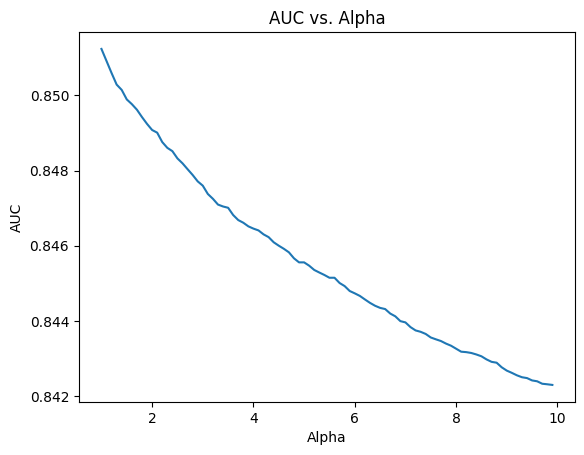

In [281]:
from sklearn.naive_bayes import MultinomialNB

alpha_values = np.arange(1, 10, 0.1)
res = pd.Series([get_auc_CV(MultinomialNB(alpha=i)) for i in alpha_values],
                index=alpha_values)
best_alpha = np.round(res.idxmax(), 2)
print('Best alpha: ', best_alpha)

plt.plot(res)
plt.title('AUC vs. Alpha')
plt.xlabel('Alpha')
plt.ylabel('AUC')
plt.show()

In [284]:
from sklearn.metrics import accuracy_score, roc_curve, auc

def evaluate_roc(probs, y_true):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')

    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')

    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

AUC: 0.8483
Accuracy: 76.95%


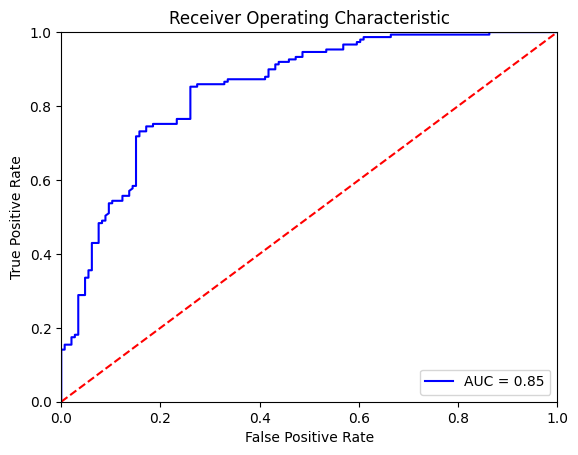

In [285]:
# Compute predicted probabilities
nb_model = MultinomialNB(alpha=1.0)
nb_model.fit(X_train_tfidf, y_train)
probs = nb_model.predict_proba(X_val_tfidf)

# Evaluate the classifier
evaluate_roc(probs, y_val)

### fine-tuning BERT

In [380]:
def text_preprocessing(text):
    """
    - Remove entity mentions (eg. '@')
    - Correct errors
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """
    # Remove '@'
    text = re.sub(r'(@.*?)[\s]',' ', text)

    # Replace '<\br>' with ' '
    text = re.sub(r'<\br>;', ' ', text)

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [381]:
# Print sentence 0
print('Original: ', X[0])
print('Processed: ', text_preprocessing(X[0]))

Original:  Honestly, I would not stay here again. Our room wasn't clean when we arrived (dirty sheets, toilet super disgusting) and wasn't cleaned until a couple hours after we checked in.  Maintenance definitely needs to be done on the place. Our toilet didn't really work (I had to fix it one morning, because the handle was completely disconnected from the toilet, the water wouldn't stop running, & it wouldn't flush), the faucet handle on the sink kept falling off, & there's a TON of trash in the front yard.<br/>The room is also super noisy, the floor upstairs is extremely creaky so you can hear absolutely any movement from the neighbors on the upper floor, which can keep you up late into the night.<br/>Also important to note: a dog lives here, which doesn't seem to be mentioned anywhere but should be noted in case someone has an allergy.<br/>It's a good location, close to public transit, and the host is responsive, but it's waaaaay too frustrating to deal with everything else.
Proces

In [382]:
from transformers import RobertaTokenizer

# Load the BERT tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', do_lower_case=True)

# Create a function to tokenize a set of texts
def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing(sent),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,             # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )

        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [392]:
# Concatenate train data and test data (test data is already a subset of train data)
all_data = data.review.values

# Encode our concatenated data
encoded_data = [tokenizer.encode(sent, add_special_tokens=True) for sent in all_data]

# Find the maximum length
max_len = max([len(sent) for sent in encoded_data])
print('Max length: ', max_len)

Max length:  1674


In [393]:
# Specify `MAX_LEN`
MAX_LEN = 64

# Print sentence 0 and its encoded token ids
token_ids = list(preprocessing_for_bert([X[0]])[0].squeeze().numpy())
print('Original: ', X[0])
print('Token IDs: ', token_ids)

# Run function `preprocessing_for_bert` on the train set and the validation set
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(X_train)
val_inputs, val_masks = preprocessing_for_bert(X_val)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:  Honestly, I would not stay here again. Our room wasn't clean when we arrived (dirty sheets, toilet super disgusting) and wasn't cleaned until a couple hours after we checked in.  Maintenance definitely needs to be done on the place. Our toilet didn't really work (I had to fix it one morning, because the handle was completely disconnected from the toilet, the water wouldn't stop running, & it wouldn't flush), the faucet handle on the sink kept falling off, & there's a TON of trash in the front yard.<br/>The room is also super noisy, the floor upstairs is extremely creaky so you can hear absolutely any movement from the neighbors on the upper floor, which can keep you up late into the night.<br/>Also important to note: a dog lives here, which doesn't seem to be mentioned anywhere but should be noted in case someone has an allergy.<br/>It's a good location, close to public transit, and the host is responsive, but it's waaaaay too frustrating to deal with everything else.
Token 

In [394]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 32

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

In [395]:
%%time
import torch
import torch.nn as nn
from transformers import RobertaModel

# Create the BertClassfier class
class RobertaClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(RobertaClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 2

        # Instantiate BERT model
        self.bert = RobertaModel.from_pretrained('roberta-base')

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            #nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False

    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)

        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

CPU times: user 52 µs, sys: 0 ns, total: 52 µs
Wall time: 55.8 µs


In [396]:
from transformers import AdamW, get_linear_schedule_with_warmup

def initialize_model(epochs=4):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    roberta_classifier = RobertaClassifier(freeze_bert=False)

    # Tell PyTorch to run the model on GPU
    roberta_classifier.to(device)

    # Create the optimizer
    optimizer = torch.optim.AdamW(roberta_classifier.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return roberta_classifier, optimizer, scheduler

In [397]:
import random
import time

# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch

            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")

    print("Training complete!")


def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

In [399]:
set_seed(42)    # Set seed for reproducibility
roberta_classifier, optimizer, scheduler = initialize_model(epochs=4)
train(roberta_classifier, train_dataloader, val_dataloader, epochs=4, evaluation=True)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.649911   |     -      |     -     |   7.18   
   1    |   40    |   0.545615   |     -      |     -     |   7.03   
   1    |   60    |   0.511445   |     -      |     -     |   7.17   
   1    |   80    |   0.462830   |     -      |     -     |   7.27   
   1    |   82    |   0.428538   |     -      |     -     |   0.72   
----------------------------------------------------------------------
   1    |    -    |   0.541000   |  0.476869  |   81.21   |   30.70  
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   2    |   20    |   0.429678   |     -      |     -     |   7.54   
   2    |   40    |   0.489783   |     -      |     -     |   7.3

In [400]:
import torch.nn.functional as F

def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)

    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

AUC: 0.8723
Accuracy: 79.32%


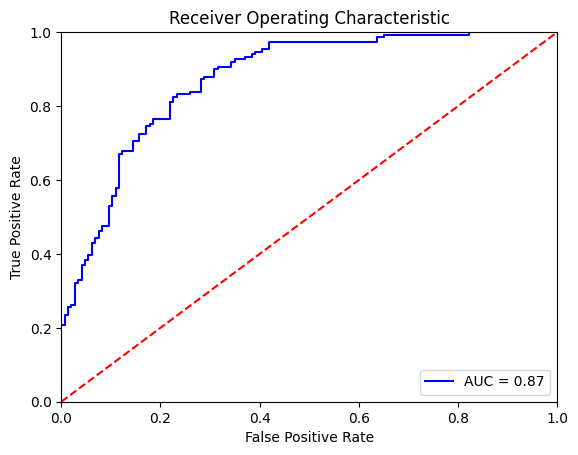

In [401]:
# Compute predicted probabilities on the test set
probs = bert_predict(roberta_classifier, val_dataloader)

# Evaluate the Bert classifier
evaluate_roc(probs, y_val)

In [402]:
# Concatenate the train set and the validation set
full_train_data = torch.utils.data.ConcatDataset([train_data, val_data])
full_train_sampler = RandomSampler(full_train_data)
full_train_dataloader = DataLoader(full_train_data, sampler=full_train_sampler, batch_size=32)

# Train the Bert Classifier on the entire training data
set_seed(42)
bert_classifier, optimizer, scheduler = initialize_model(epochs=2)
train(bert_classifier, full_train_dataloader, epochs=2)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.625199   |     -      |     -     |   7.28   
   1    |   40    |   0.549731   |     -      |     -     |   7.24   
   1    |   60    |   0.505859   |     -      |     -     |   7.30   
   1    |   80    |   0.515395   |     -      |     -     |   7.31   
   1    |   92    |   0.500592   |     -      |     -     |   4.28   
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   2    |   20    |   0.463795   |     -      |     -     |   7.43   
   2    |   40    |   0.479584   |     -      |     -     |   7.18   
   2    |   60    |   0.420411   |     -      |     -     |   7.17   
   2    |   80    |   0.424868   |     -      |     -     |   7.15

In [341]:
test_data.sample(5)

,id,review
820,19244237,Neto was a great host.
313,30554355,"Great stay, everything looks exactly like the ..."
1355,51799070,Eduardo is the nicest and friendliest of hosts...
1423,821188169022006967,"Really nice apartment, in a quiet residence an..."
1070,42876407,The apartment is lovely and very close to a su...


In [403]:
# Run `preprocessing_for_bert` on the test set
print('Tokenizing data...')
test_inputs, test_masks = preprocessing_for_bert(test_data.review)

# Create the DataLoader for our test set
test_dataset = TensorDataset(test_inputs, test_masks)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=32)

Tokenizing data...


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [417]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, test_dataloader)

# Get predictions from the probabilities
threshold = 0.9177  # manually adjusted to get predicted non-negative reviews = 105
preds = np.where(probs[:, 1] > threshold, 1, 0)

# Number of reviews predicted non-negative
print("Number of reviews predicted non-negative: ", preds.sum())

Number of reviews predicted non-negative:  108


In [418]:
output = test_data[preds==1]
list(output.sample(20).review)

['HIGHLY RECOMMEND! We flew to NY For my 14yr old birthday celebration. Location is perfect! Very clean, and very modern! Host is AMAZING!!',
 'Amazing stay with a very modern vibe. Definitely a great stay to take a special someone.',
 'Great place in a quiet neighbourhood with a sense of a home. A pieceful oasis in the big city. Amazing hospitality by Lidia which was there to help at any time.',
 'Excellent place, just as described. Great location in a nice and quiet neighborhood, easy communication with host. Everything you might need is on the studio. Clean and cozy, will definitely stay here again.',
 'I absolutely loved my stay. The host was extremely communicative and helpful. The place is beautiful, spacious, clean, and super close to a train station. The rooftop offers and incredible view of the city and I would gladly book again.',
 "Josie is the most gracious host.  I arrived with my two teenage boys, and thoughtful touches like milk, juice and little cereal boxes, were waiti

In [420]:
torch.save(bert_classifier, '/content/drive/MyDrive/inputs/roberta-50split-set')

### testing on standard BERT (not fine-tuned)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


AUC: 0.4958
Accuracy: 50.51%


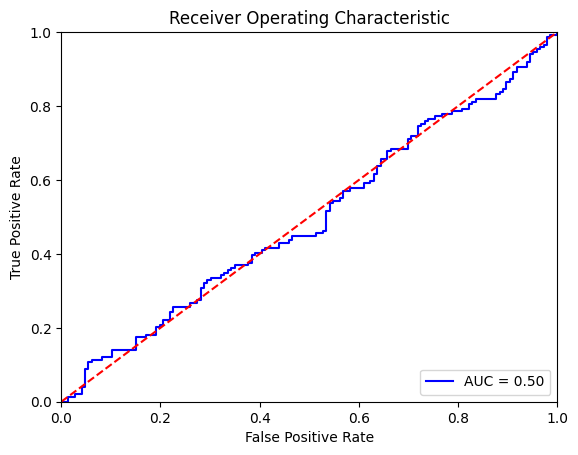

In [343]:
roberta_classifier, optimizer, scheduler = initialize_model(epochs=2)


# Compute predicted probabilities on the validation set
probs = bert_predict(roberta_classifier, val_dataloader)

# Evaluate the Bert classifier on the validation set
evaluate_roc(probs, y_val)

In [351]:
# Concatenate the train set and the validation set
full_train_data = torch.utils.data.ConcatDataset([train_data, val_data])
full_train_sampler = RandomSampler(full_train_data)
full_train_dataloader = DataLoader(full_train_data, sampler=full_train_sampler, batch_size=32)

# Train the Bert Classifier on the entire training data
set_seed(42)
roberta_classifier, optimizer, scheduler = initialize_model(epochs=2)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [352]:
# Run `preprocessing_for_bert` on the test set
print('Tokenizing data...')
test_inputs, test_masks = preprocessing_for_bert(test_data.review)

# Create the DataLoader for our test set
test_dataset = TensorDataset(test_inputs, test_masks)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=32)

Tokenizing data...


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [363]:
# Compute predicted probabilities on the test set
probs = bert_predict(roberta_classifier, test_dataloader)

# Get predictions from the probabilities
threshold = 0.5111  # manually adjusted to get predicted non-negative reviews = 105
preds = np.where(probs[:, 1] > threshold, 1, 0)

# Number of reviews predicted non-negative
print("Number of reviews predicted non-negative: ", preds.sum())

Number of reviews predicted non-negative:  109


In [370]:
output = test_data[preds==1]
list(output.sample(20).review)

['NEVER GOT TO STAY HERE <br/>NO COMMUNICATION FROM THE BNB HOST.',
 'Great host !!',
 'Point positif: Près du métro, propre et lits confortables. Points négatifs: pas de salon ou cuisine assez grande pour se rassembler, manque de commodité dans la cuisine, Rez de chaussée non accessible sauf pour se rendre à l’étage.',
 '💯',
 'Karen was an amazing host!',
 'Luz es una anfitriona estupenda,esta súper atenta a cualquier duda que puedas tener y siempre dispuesta a ayudar igual que Andrew.<br/>Todo fue genial!',
 'Great place..perfect location.<br/>Hotel looks very good and the rooms are nice and clean',
 '👍🏽',
 'WORST COMMUNICATION EVER',
 "Tres bon Airbnb, plus grand que sur les photos, calme et central. Nous avons vrainent apprecié notre séjour dans l'appartement de Chloé. Les articles pour cuisiner etaient un peu limités, mais Chloé nous a rapidement indiqué où nous pouvions nous en acheter dans son quartier. Arrivée très facile, air climatisé très puissante qui nous a permis de très 